In [ ]:
!cp drive/MyDrive/NN_Energy/Dist_for_Collab.tar.gz .
!cp drive/MyDrive/NN_Energy/Z_results_zenith.hdf5 .
!tar -zxvf Dist_for_Collab.tar.gz

In [ ]:
!nvidia-smi

In [3]:

test_interval=5 

# import libraries
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import shutil
import re
import math
import time
import glob
import gzip
import sys
import matplotlib.pyplot as plt
import os
import random
import h5py


In [4]:
class EventsData(Dataset):
    def __init__(self,data_dir,per=100,batch_size=500):
        # Save the directory of the data
        self.data_dir = data_dir
        
        # Get the names of the files
        self.names=glob.glob(str(data_dir)+'*.hdf5')
        # Number of files in the dir
        self.size_dir=len(self.names)
        
        # Set the files acording to the percentage
        self.size_dir=math.ceil(len(self.names)*(per/100))
        self.names=self.names[0:self.size_dir]
        # Sort the files alphabetically
        self.names = sorted(self.names)
        #random.shuffle(self.names)
        
        # Get the number of events per file
        print(self.names[1])
        f = h5py.File(self.names[0],'r')
        self.size_file=f['y'].shape[0]
        
        # Get the total number of events
        self.total_events=0
        for name in self.names:
            f = h5py.File(name,'r')
            y = f['y']
            self.total_events+=y.shape[0]

        # Read the results from the Zenith and load them to RAM
        zn = h5py.File('Z_results_zenith.hdf5','r')
        # Identify if the dataloader is loading train, validation or test results
        dataset_type = self.names[1][15]
        print(dataset_type)
        if dataset_type == 'r':
          print("Train dataset type")
          self.z_zenith = torch.tensor([zn['Train_Z']])
        if dataset_type == 'a':
          print("Validation dataset type")
          self.z_zenith = torch.tensor([zn['Val_Z']])
        if dataset_type == 'e':
          print("test dataset type")
          self.z_zenith = torch.tensor([zn['Test_Z']])
        
        self.z_zenith=torch.squeeze(self.z_zenith)
        print(self.z_zenith.size())
        # Load the whole dataset into the RAM
        self.data_big = torch.zeros(self.total_events,25,161)
        self.target_big = torch.zeros(self.total_events)
        

        print("Reading "+str(self.data_dir)+" with "+str(self.size_dir)+" files.")
        for a in range(len(self.names)):
            f = h5py.File(self.names[a],'r')
            # The input of the network will the same for the Zenith model, distance, etc
            self.data_big[(a*1000):(((a+1)*1000))]=torch.tensor(f['X1'][:,:,:,0])
            # For distance in the target data, use the second component 
            # As the dimentions for the X2 tensor are:
            # 0 -> Result from the BBFit
            # 1 -> Distance 
            # 2 -> Zc
            self.target_big[(a*1000):(((a+1)*1000))]=torch.tensor(f['X2'][:,1])
            self.target_big[(a*1000):(((a+1)*1000))].size()
        



        # Number of iterations to finish the dataset
        self.batch_size=batch_size
        self.iters=math.floor(self.total_events/batch_size)
        self.iters_per_file= math.floor(self.size_file/batch_size)
        self.real_events=self.batch_size*self.iters

        print("There are "+str(self.total_events)+" events.")
        print("In "+str(self.size_dir)+" separate files.")
        print("Each file containing "+str(self.size_file)+" events.")
        print("In "+str(self.iters)+" iterations")
        print("The real number of events is: "+str(self.real_events))
        


    def get_len(self):
        return self.real_events
    
    def get_iter(self):
        # Returns the number of iteracions og getitem to finish the dataset
        return self.iters

    def get_batch(self, idx):
        # Get the file that shall be opened
        ind1=idx*self.batch_size
        ind2=((idx+1)*self.batch_size)
        
        
        data=self.data_big[ind1:ind2,:,:]
        target=self.target_big[ind1:ind2]
        Z=self.z_zenith[ind1:ind2]
        
        # Get the events that will be extracted from the file
        #ind2=ind+self.batch_size
        
        data=data.unsqueeze(dim=3)
        target=target.unsqueeze(dim=1)
        
        
        
        #Only for conv with modulus
        data=data.transpose(1,3)
        data=data.transpose(2,3)    
        
        return data.float(),target.float(),Z.float()

In [5]:
def init_data(percentage,batch):
        # Save for exporting
        percentage=percentage
        batch_size=batch
        # Initialize the datasets
        print("Train dataset:")
        training_data = EventsData(data_dir='Mod_full_dist/train_data_fixed/', per=percentage, batch_size=batch);
        print()

        print("Validation dataset:")
        validation_data=EventsData(data_dir='Mod_full_dist/validation_data_fixed/', per=percentage, batch_size=batch);
        print()

        print("Test dataset:")
        test_data=EventsData(data_dir='Mod_full_dist/test_data_fixed/', per=percentage, batch_size=batch);
        print()

        return training_data,validation_data,test_data

In [6]:
batch_size_used = 1000 # Has to be fixed
percentage_used = 100

train,val,test = init_data(percentage_used,batch_size_used)

Train dataset:
Mod_full_dist/train_data_fixed/train_dataset_1.hdf5
r
Train dataset type
torch.Size([862000, 2])
Reading Mod_full_dist/train_data_fixed/ with 862 files.
There are 862000 events.
In 862 separate files.
Each file containing 1000 events.
In 862 iterations
The real number of events is: 862000

Validation dataset:
Mod_full_dist/validation_data_fixed/validation_dataset_1.hdf5
a
Validation dataset type
torch.Size([247000, 2])
Reading Mod_full_dist/validation_data_fixed/ with 247 files.
There are 247000 events.
In 247 separate files.
Each file containing 1000 events.
In 247 iterations
The real number of events is: 247000

Test dataset:
Mod_full_dist/test_data_fixed/test_dataset_1.hdf5
e
test dataset type
torch.Size([120000, 2])
Reading Mod_full_dist/test_data_fixed/ with 120 files.
There are 120000 events.
In 120 separate files.
Each file containing 1000 events.
In 120 iterations
The real number of events is: 120000



In [7]:
# Nueva función de coste
def custom_loss(target,mu,sigma):
    # Create the normal distribution
    #print(mu[1])
    dist = torch.distributions.Normal(loc=mu, scale=sigma)
    # Obtain the -PDF and reduce it to the mean
    # Shall return a real number only
    loss = torch.mean(-dist.log_prob(target))
    return loss

In [8]:



def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

# This class will contain a NN model and all of its functions and data 
# It won't be pushed to the GPU
class Net_Info():
    # Constructor for the predictor
    # Data regarding the NN shall be passed here
    def __init__(self,model,folder,name):
        # Route to save the model
        self.folder=folder
        self.name=name

        # Set the optimizer and loss functions
        self.optimizer=optim.SGD(model.parameters(),lr=0.002)
        #self.loss_function=nn.L1Loss()
        
    # Function to set the model name and folder
    # Used to save the name in it
    def location(self,name,folder):
        self.folder=folder
        self.model_name=name

    def init_data(self,percentage,batch):
        # Save for exporting
        self.percentage=percentage
        self.batch_size=batch
        

    # Save all the data from the class, except the arquitecture of the net
    def save_params(self,model):
        # Open the text file
        file1=open(str(self.folder)+"/"+str(self.name)+"_params.txt","w+")
        file1.write("Data Info:\n")
        file1.write(str(self.percentage)+"\n"+str(self.batch_size)+"\n"+str(self.n_epochs)+"\n")
        file1.write("Last Val Info:\n")
        file1.write(str(self.valid_loss_min)+"\n")
        file1.write("Last Errors:\n")
        file1.write(str(self.MAE)+"\n"+ str(self.RMSE)+"\n")
        file1.write("Loss and Optimier\n")
        #file1.write(str(self.loss_function)+"\n")
        file1.write(str(self.optimizer))
        file1.close()
        file2=open(str(self.folder)+"/"+str(self.name)+"_arquitecture.txt","w+")
        file2.write(str(model))
        file2.close()

    def plot_loss(self):
        plt.figure(figsize=(10,10),dpi=800)
        plt.plot(self.train_loss_temp[:self.n_epochs],linewidth=3.0,color="r")
        plt.plot(self.valid_loss_temp[:self.n_epochs],linewidth=3.0,color="g")
        plt.title('{} | MAE = {:.3f} | RMSE = {:.3f}'.format(self.name,self.MAE,self.RMSE))
        plt.ylabel('Loss')
        plt.xlabel('Epochs')
        plt.legend(['Training Loss','Validation Loss'], loc = 'upper left')
        # plt.show()
        plt.savefig(str(self.folder)+"/"+str(self.name)+"_loss.jpg")

    def plot_pred(self):
        plt.figure(figsize=(5,5),dpi=100)
        plt.scatter(self.target_temp,self.output_temp)
        plt.xlabel('True Values ')
        plt.ylabel('Predictions ')
        plt.axis('equal')
        plt.axis('square')
        plt.title("Target vs. Prediction values of "+str(self.name))
        plt.savefig(str(self.folder)+"/"+str(self.name)+"_scatter.jpg")
        plt.close();
      
        

    def train_model(self,net,n_epochs,test_inter,train,val,test,valid_loss_min=np.Inf):
        self.n_epochs = n_epochs
        # If valid loss is not inf, the load the model
        if valid_loss_min>1000:
            self.valid_loss_min = np.Inf # track change in validation loss
        else:
            self.valid_loss_min = valid_loss_min
            net.load_state_dict(torch.load(str(self.folder)+'/'+str(self.name)+'.pt'))
            

        self.train_loss_temp = np.zeros([n_epochs,1])
        self.valid_loss_temp = np.zeros([n_epochs,1])
        # If this number goes to zero, the training will stop
        last_save=10
        for epoch in range(1, n_epochs+1):
            # keep track of training and validation loss
            train_loss = 0.0
            valid_loss = 0.0



            # train the net #
            net.train()
            for batch in range(train.get_iter()):
                # Get the data
                data,target,Z=train.get_batch(batch)
                # move tensors to GPU if CUDA is available
                data, target, Z = data.cuda(), target.cuda(), Z.cuda()
                # clear the gradients of all optimized variables
                self.optimizer.zero_grad()
                # forward pass: compute predicted outputs by passing inputs to the net
                mu,sigma = net(data,Z)
                # calculate the batch loss
                loss = custom_loss(target,mu,sigma)
                # backward pass: compute gradient of the loss with respect to net parameters
                loss.backward()
                # perform a single optimization step (parameter update)
                self.optimizer.step()
                # update training loss
                # and reboot if nan
                if math.isnan(loss.item()) == True:
                    net.apply(weight_reset)
                    print("Reseteo insacioso")
                train_loss += loss.item()


            # validate the net #
            net.eval()
            for batch in range(val.get_iter()):
                # Get the data
                data,target,Z=train.get_batch(batch)
                # move tensors to GPU if CUDA is available
                data, target, Z = data.cuda(), target.cuda(), Z.cuda()
                # forward pass: compute predicted outputs by passing inputs to the net
                mu,sigma = net(data,Z)
                # calculate the batch loss
                loss = custom_loss(target,mu,sigma)
                # update average validation loss 
                valid_loss += loss.item()
            #el data,target
            # calculate average losses
            train_loss = train_loss/train.get_len()
            valid_loss = valid_loss/val.get_len()

            # Append the losses to the historical ones
            self.train_loss_temp[epoch-1]=train_loss
            self.valid_loss_temp[epoch-1]=valid_loss            

            # print training/validation statistics 
            print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
                epoch, train_loss, valid_loss))
            # Save the net if the loss goes down
            # Show also the % of error down
            if valid_loss <= self.valid_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving net ...'.format(
                self.valid_loss_min,
                valid_loss))
                torch.save(net.state_dict(), str(self.folder)+'/'+str(self.name)+'.pt')
                # Show by how much the validation loss has dropped
                valid_percent=((self.valid_loss_min-valid_loss)/self.valid_loss_min)*100
                print('Validation loss has dropped {:.2f}%'.format(valid_percent))
                self.valid_loss_min = valid_loss
                if valid_percent>=1:
                    last_save=10
                    print("Keep training")
                else:
                    last_save += 2
            else:
                last_save -= 1;
                
            # Show iterations to stop
            print('Training will stop in '+str(last_save)+" epochs ...")
            print("")
            
            # Check the test error and the 
            if (epoch%test_interval)==0:
                # self.target_temp=np.zeros([self.test_data.get_len(),1])
                # self.output_temp=np.zeros([self.test_data.get_len(),1])
                # Init the errors
                MAE=0
                MSE=0
                for batch in range(test.get_iter()):
                    # Get the data
                    data,target,Z=test.get_batch(batch)
                    # move tensors to GPU if CUDA is available
                    data,Z = data.cuda(),Z.cuda()
                    # Get the results from the foward pass to the CPU 
                    # And get it as an numpy matrix
                    mu,sigma = net(data,Z)#.cpu().detach().numpy()
                    target=target.numpy()
                    output = mu.cpu().detach().numpy()
                    # calculate the batch loss
                    MAE += np.sum(np.abs(output-target))
                    MSE += np.sum((output-target)**2)
                    # print(output)
                    # Append to the historical value
                    # self.target_temp[(batch*self.batch_size):((batch+1)*self.batch_size)]=target
                    # self.output_temp[(batch*self.batch_size):((batch+1)*self.batch_size)]=output

                # self.plot_pred()
                # calculate average losses
                self.MAE = MAE/test.get_len()
                self.RMSE = np.sqrt(MSE/test.get_len())
                    
                print("The MAE is "+str(self.MAE))
                print("The RMSE is "+str(self.RMSE))

            # Check if the net is not progressing
            if last_save<=0:
                print("Early stopping")
                self.n_epochs=epoch
                break
        # Compute the test error for the best performing model
        # Load the model
        net.load_state_dict(torch.load(str(self.folder)+'/'+str(self.name)+'.pt'))
        MAE=0
        MSE=0
        for batch in range(test.get_iter()):
            # Get the data
            data,target,Z=test.get_batch(batch)
            # move tensors to GPU if CUDA is available
            data,Z = data.cuda(),Z.cuda()
            # Get the results from the foward pass to the CPU 
            # And get it as an numpy matrix
            mu,sigma = net(data,Z)
            target=target.numpy()
            output = mu.cpu().detach().numpy()
            # calculate the batch loss
            MAE += np.sum(np.abs(output-target))
            MSE += np.sum((output-target)**2)
            # print(output)
            # Append to the historical value
            # self.target_temp[(batch*self.batch_size):((batch+1)*self.batch_size)]=target
            # self.output_temp[(batch*self.batch_size):((batch+1)*self.batch_size)]=output

        # self.plot_pred()
        # calculate average losses
        self.MAE = MAE/test.get_len()
        self.RMSE = np.sqrt(MSE/test.get_len())

        print("The MAE is "+str(self.MAE))
        print("The RMSE is "+str(self.RMSE))


In [9]:
# This class will contain the NN arquitecture, it will be pushed to the GPU
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        kernel_size=(2,10)
        
        #conv layer, sees 25x161x1 tensor
        self.conv1 = nn.Conv2d(1, 16, kernel_size,padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size,padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size,padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size,padding=1)

        
        self.pool = nn.MaxPool2d((2, 2))
        # Two more inputs for the mean and std of the Z component
        input_flatten = 6656 + 2
        hidden_1 = 128
        hidden_2 = 128
        hidden_3 = 32
        hidden_4 = 32
        # linear layer (784 -> hidden_1)
        self.fc1 = nn.Linear(input_flatten, hidden_1)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, hidden_3)
        self.fc4 = nn.Linear(hidden_3, hidden_4)
        self.mu = nn.Linear(hidden_4, 1)
        self.sigma = nn.Linear(hidden_4,1)
        
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.25)


    def forward(self, x,z):
        input_flatten = 6656
        # add sequence of convolutional and max pooling layers

        x = (F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
   
        #print(x.size())
        x = x.reshape(-1, input_flatten)
        x = torch.cat((x,z),dim=1)

        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        
        mu = self.mu(x)
        sigma = torch.exp(self.sigma(x))
        return mu,sigma

In [10]:
# Get the arguments from the command promt
folder_name = "Distance_MDN"
net_name = "Dist_MDNH_2_"
# 0.01 muy lento
lr = [1.0]
n_epochs =  150 # Has to be fixed
n_nets = 3

# Try to create the folder name
try:
    os.mkdir(str(folder_name))
except FileExistsError:
    print(str(folder_name)+ " directory already exists")

# Copy the modified python script with the net name into the subfolder
shutil.copy2(sys.argv[0],str(folder_name)+"/"+str(net_name)+".py")  

# Check if cuda is available and set as default device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using decive "+str(device))



Using decive cuda


In [11]:
b=1
new_name=str(net_name)+"_"+str(b)
print("Running "+str(new_name))
net=Net()
print(net)
net.cuda()
Model=Net_Info(net,folder_name,new_name)
Model.init_data(percentage_used,batch_size_used)

Running Dist_MDNH_2__1
Net(
  (conv1): Conv2d(1, 16, kernel_size=(2, 10), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(2, 10), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(2, 10), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(2, 10), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6658, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=32, bias=True)
  (mu): Linear(in_features=32, out_features=1, bias=True)
  (sigma): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [13]:
net.apply(weight_reset)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(2, 10), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(2, 10), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(2, 10), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(2, 10), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6658, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=32, bias=True)
  (mu): Linear(in_features=32, out_features=1, bias=True)
  (sigma): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [14]:
Model.optimizer=optim.Adadelta(net.parameters(),lr=0.01)
Model.train_model(net,n_epochs,test_interval,train,val,test)

Epoch: 1 	Training Loss: 0.006892 	Validation Loss: 0.003930
Validation loss decreased (inf --> 0.003930).  Saving net ...
Validation loss has dropped nan%
Training will stop in 12 epochs ...

Epoch: 2 	Training Loss: 0.004281 	Validation Loss: 0.003662
Validation loss decreased (0.003930 --> 0.003662).  Saving net ...
Validation loss has dropped 6.84%
Keep training
Training will stop in 10 epochs ...

Epoch: 3 	Training Loss: 0.003989 	Validation Loss: 0.003574
Validation loss decreased (0.003662 --> 0.003574).  Saving net ...
Validation loss has dropped 2.39%
Keep training
Training will stop in 10 epochs ...

Epoch: 4 	Training Loss: 0.003848 	Validation Loss: 0.003509
Validation loss decreased (0.003574 --> 0.003509).  Saving net ...
Validation loss has dropped 1.82%
Keep training
Training will stop in 10 epochs ...

Epoch: 5 	Training Loss: 0.003760 	Validation Loss: 0.003477
Validation loss decreased (0.003509 --> 0.003477).  Saving net ...
Validation loss has dropped 0.91%
Traini

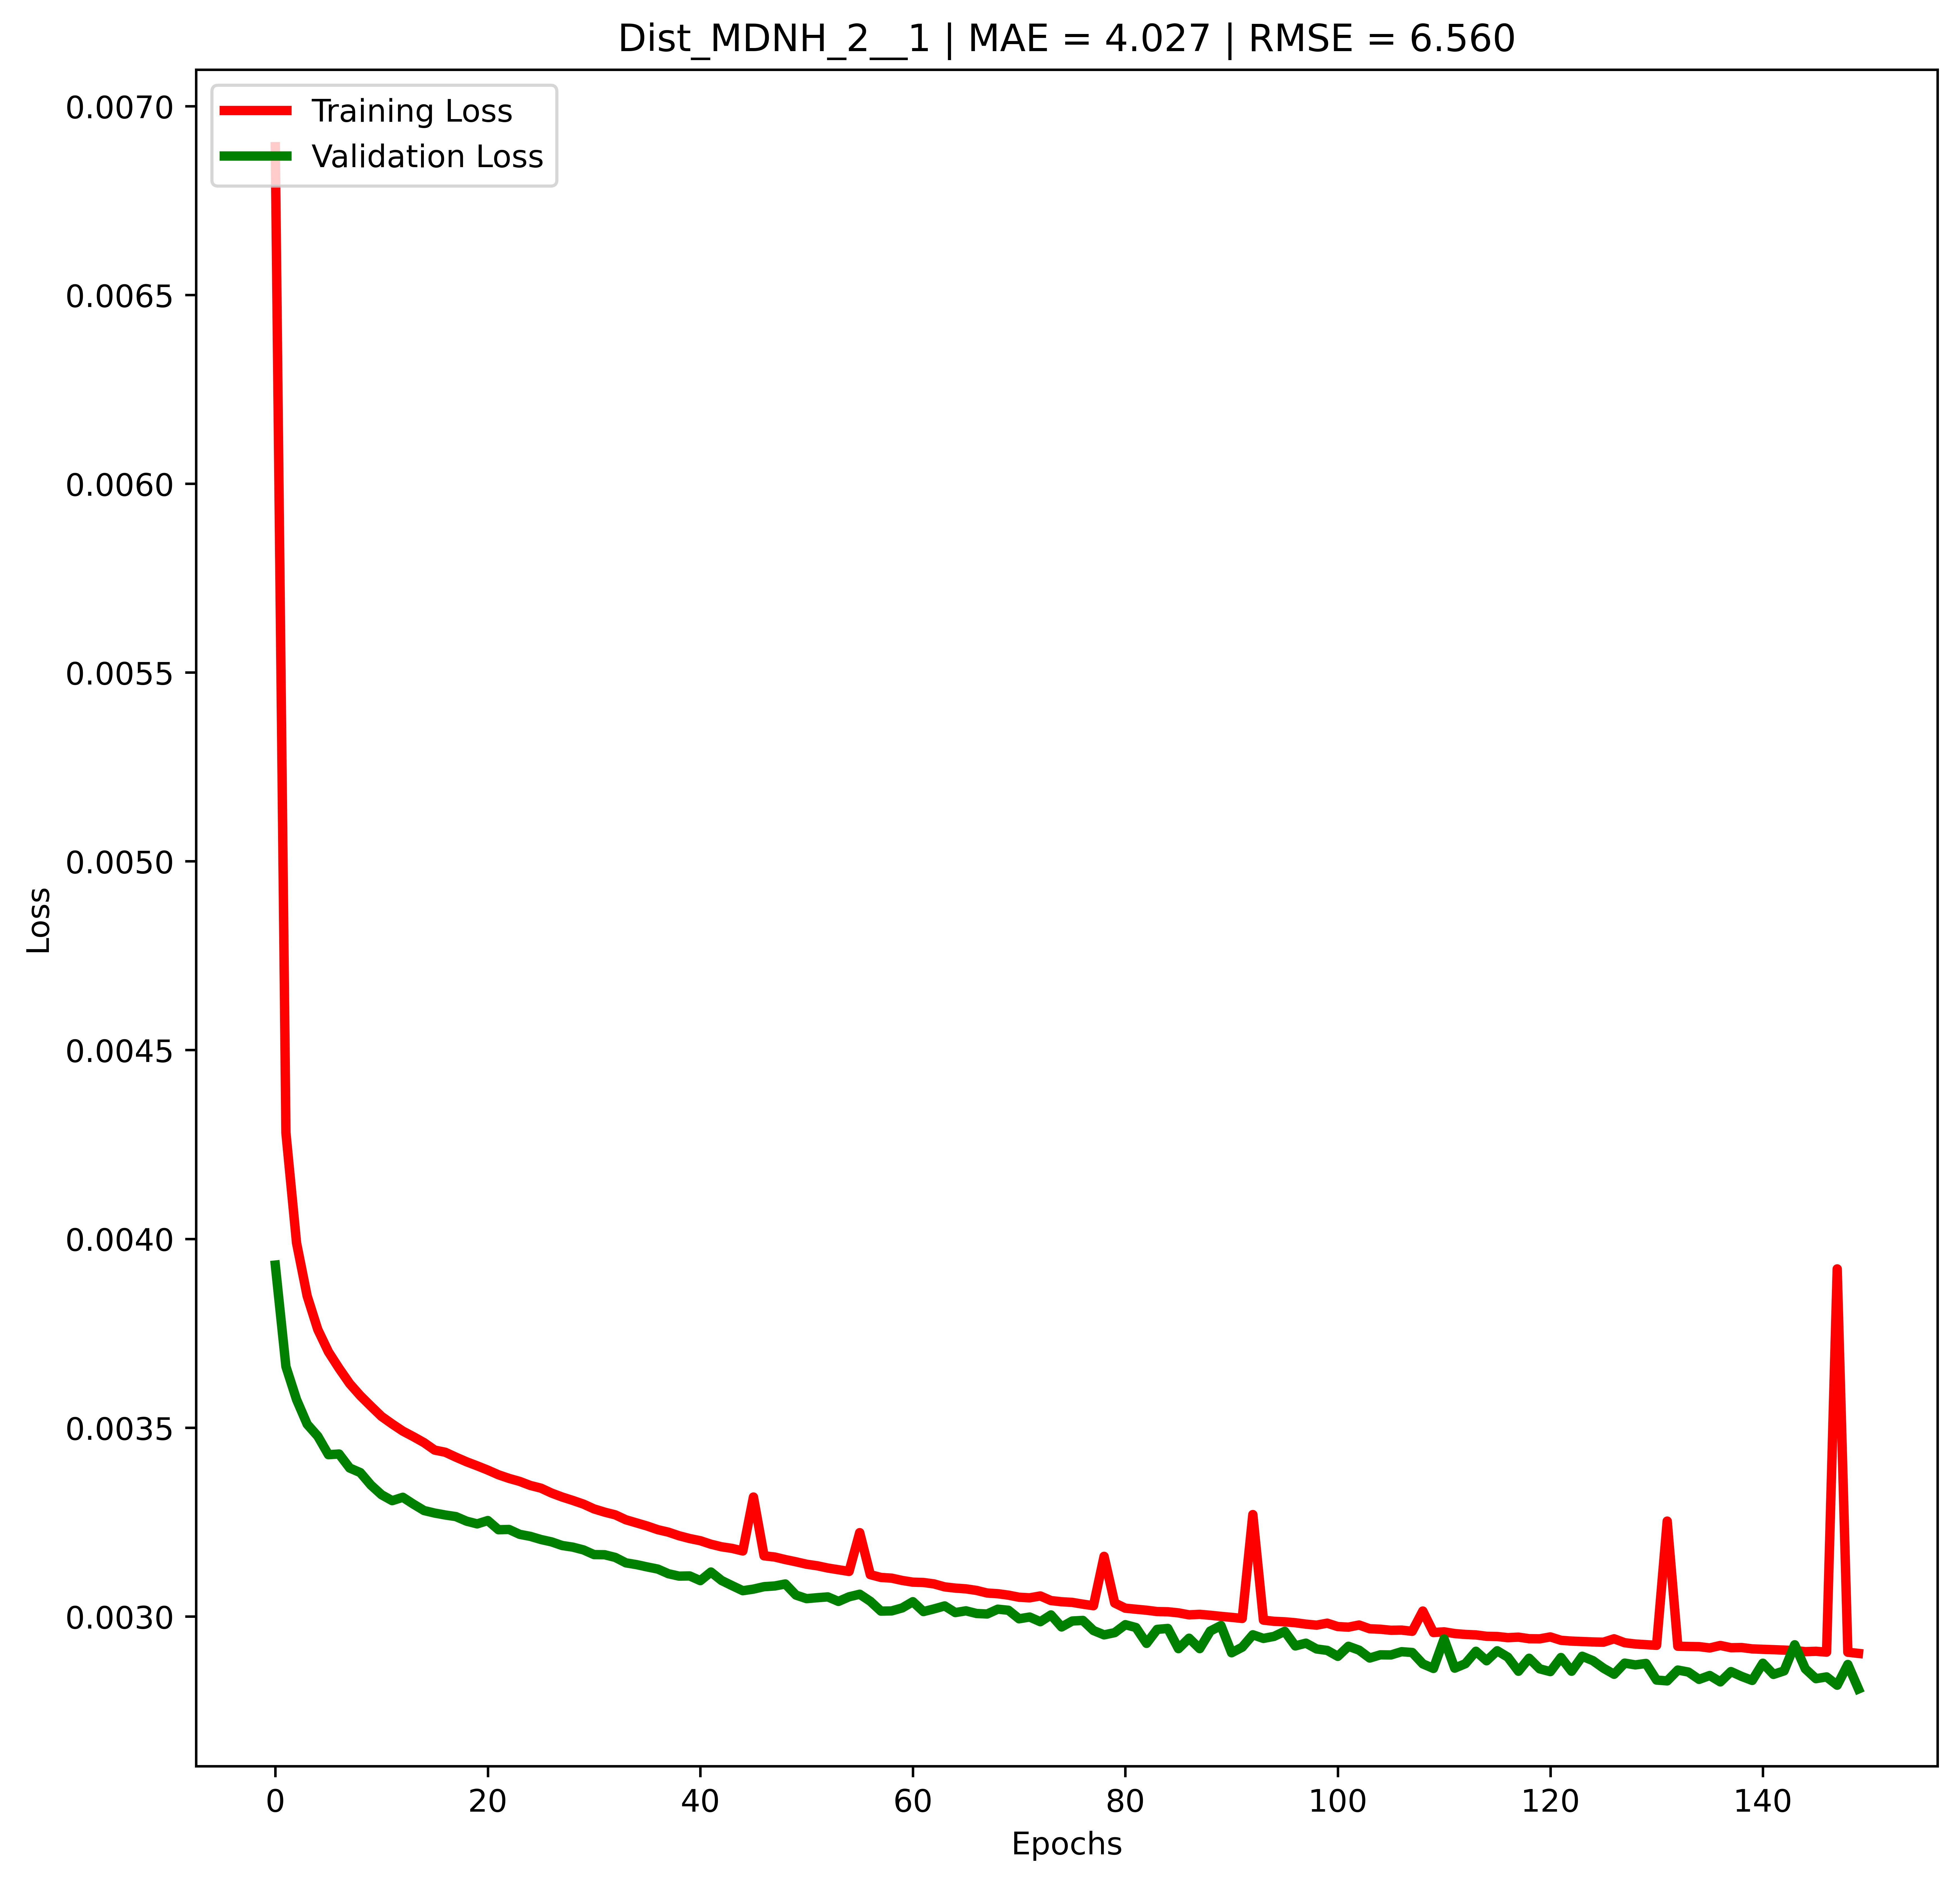

In [15]:
Model.save_params(net)
Model.plot_loss() 

In [16]:
!cp -r Distance_MDN/ drive/MyDrive/NN_Energy/